In [19]:
import os

if 'main_dir' in globals():
    os.chdir(main_dir)

import pandas as pd
from utils.load_config import load_exp_config, get_value_from_fields, get_df_historical_data

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# plt.style.use("tableau-colorblind10")
plt.style.use("seaborn-v0_8-whitegrid")

from regelum.objective import RunningObjective
from regelum.model import ModelQuadLin
import numpy as np


if os.getcwd().endswith("notebooks"):
    main_dir = os.getcwd()
    os.chdir("..")

In [20]:
try:
    from src.objective import ThreeWheeledRobotCostWithSpot
except:
    from src.objective import ThreeWheeledRobotCostWithSpot

In [21]:

objective_function = RunningObjective(ModelQuadLin(
    weights= [2, 10, 0, 0, 0],
    quad_matrix_type="diagonal",
    is_with_linear_terms=False,
))

objective_function = ThreeWheeledRobotCostWithSpot(
    quadratic_model=ModelQuadLin(
        weights= [2, 10, 0, 0, 0],
        quad_matrix_type="diagonal",
        is_with_linear_terms=False),
        spot_gain=100,
        spot_x_center=-0.5,
        spot_y_center=-0.5,
        spot_std=0.2,
    )


def get_sampling_time(exp_path):
    config = load_exp_config(exp_path)

    sampling_time = config['scenario']['sampling_time']
    if "$" in sampling_time:
        correct_fields = sampling_time.strip("\{\}$").split(".")
        sampling_time = get_value_from_fields(config, correct_fields)

    return sampling_time

def cal_obj_df(row):
    observation = np.expand_dims(np.array(row.loc[["x [m]", "y [m]", "angle [rad]"]].values), axis=0)
    action = np.expand_dims(np.array(row.loc[["velocity [m/s]", "angular velocity [rad/s]"]].values), axis=0)
    
    return objective_function(observation, action)

In [22]:
x_lim = y_lim = [-1, 0]
X = np.arange(x_lim[0], x_lim[1], 0.01)
Y = np.arange(y_lim[0], y_lim[1], 0.01)

X, Y = np.meshgrid(X, Y)
Z = []
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z.append(objective_function.cal_spot_penalty(observation=np.array([[X[i, j], Y[i, j]]])))

Z = np.array(Z).reshape((X.shape[0], X.shape[1]))

In [23]:
class ExperimentData():
    def __init__(self, exp_path, chosen_name, **kwarg) -> None:
        self.df = get_df_historical_data(exp_path, chosen_name)
        self.sampling_time = get_sampling_time(exp_path)
        
        self.correct_column_name()
        self.calculate_objective_values()

    def correct_column_name(self):
        replacements = {
            "x_rob"   :     "x [m]", 
            "y_rob"   :    "y [m]",
            "vartheta":       "angle [rad]",
            "v"       : "velocity [m/s]",
            "omega"   :    "angular velocity [rad/s]",
        }

        new_columns = []
        if "x [m]" not in self.df.columns.values:
            for col in self.df.columns.values:
                new_columns.append(col if col not in replacements else replacements[col])

            self.df.columns = new_columns

    def calculate_objective_values(self):
        self.df["objective_value"] = self.df.apply(cal_obj_df, axis=1)
        self.df["accumulative_objective"] = self.df["objective_value"].apply(lambda x: x*self.sampling_time).cumsum()

    def plot_cost(self, ax, exp_name="", with_others=False):
        titles = [
            "Objective value",
            "Accumulative objective value"
        ]
        targets = [
            "objective_value",
            "accumulative_objective"
        ]
        if not with_others:
            titles[0] += "of {} \n final cost: {:0.2f}".format(exp_name, self.df.accumulative_objective.max())
            titles[1] += "of {} \n final cost: {:0.2f}".format(exp_name, self.df.accumulative_objective.max())

        for i in range(len(titles)):
            ax[i].set_title(titles[i])
            self.df.plot(x="time", y=targets[i], ax=ax[i], label=exp_name if with_others else None, alpha=0.8)
            ax[i].grid()

    def plot_trajectory(self, ax, exp_name=""):
        ax.set_title("Trajectory")
        ax.plot(self.df["x [m]"], self.df["y [m]"], label=exp_name, alpha=0.8)
        ax.grid()
    

In [24]:
experiment_collections = {
    "CALF controller": {
        "exp_path": "/home/robosrv/huyhoang/regelum-playground/regelum_data/outputs/2024-08-20/15-51-23/0",
        "chosen_name": "observations_actions_it_00001"
    },
    "MPC controller": {
        "exp_path": "/home/robosrv/huyhoang/regelum-playground/regelum_data/outputs/2024-08-20/15-53-14/0",
        "chosen_name": "observations_actions_it_00001"
    },
    "SARSA_m controller": {
        "exp_path": "/home/robosrv/huyhoang/regelum-playground/regelum_data/outputs/2024-08-20/15-56-16/0",
        "chosen_name": "observations_actions_it_00001"
    },
    "Nominal controller": {
        "exp_path": "/home/robosrv/huyhoang/regelum-playground/regelum_data/outputs/2024-08-20/15-59-31/0",
        "chosen_name": "observations_actions_it_00001"
    },
    "PPO controller": {
        "exp_path": "/home/robosrv/huyhoang/regelum-playground/regelum_data/outputs/2024-08-20/16-01-28/0",
        "chosen_name": "observations_actions_it_00001"
    },
}

for exp in experiment_collections:
    experiment_collections[exp]["obj"] = ExperimentData(**experiment_collections[exp])


## Re-calculate objective

### Define objective function

In [25]:

observation = np.array([[1, 1, 0.01]])
actions = np.array([[1, 1]])
objective_function(observation, actions)

12.0

## Plot objective

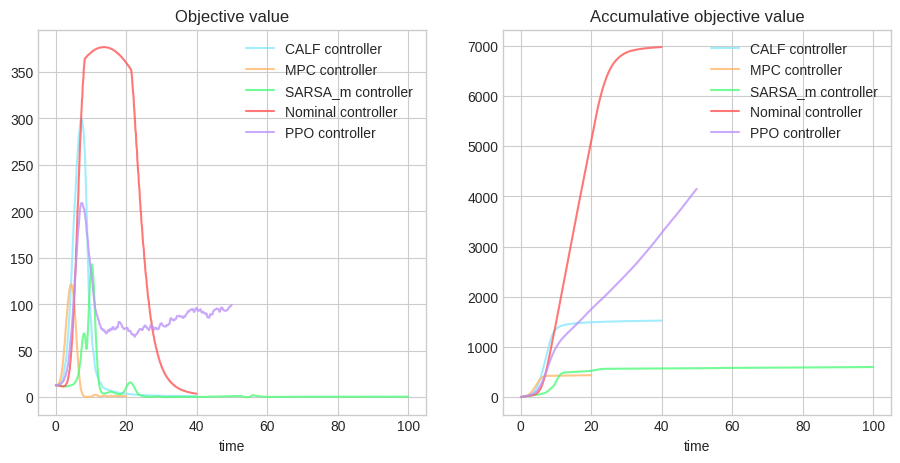

In [26]:
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

for id, exp in enumerate(experiment_collections):
    experiment_collections[exp]["obj"].plot_cost(ax, exp, with_others=True)

for _ax in ax:
    _ax.grid()
# ppo_exp.plot_cost(ax[0], "PPO Controller")
# nominal_exp.plot_cost(ax[1], "Nominal Controller")

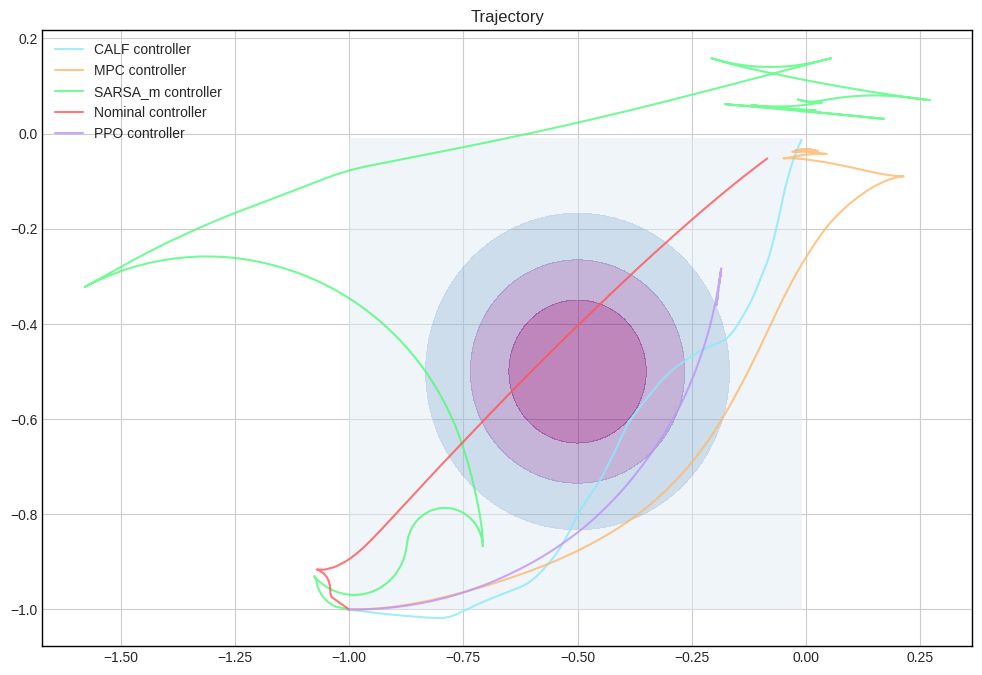

In [31]:
plt.clf()
fig, ax = plt.subplots()

plt.figure(facecolor='white')  # Set figure background color
plt.rcParams.update({"figure.figsize" : (12, 8),
                     "axes.facecolor" : "white",
                     "axes.edgecolor":  "black"})

cs = ax.contourf(X, Y, Z, alpha=0.5, levels=3, cmap="BuPu")
cs.cmap.set_over('red')
cs.cmap.set_under('blue')
cs.changed()

for id, exp in enumerate(experiment_collections):
    experiment_collections[exp]["obj"].plot_trajectory(ax, exp)

ax.grid()
ax.legend()
fig.savefig("test.png")